In [738]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from collections import deque
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

In [739]:
daysToPredict = 7
country = 'Saudi Arabia'
feature = "deaths" # 'confirmed' or 'deaths'
numFeatures = 1
learningRate = 0.001
inputSize = 7

In [740]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_' + feature + '_global.csv')
print(df.shape)

(271, 321)


In [741]:
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,11/24/20,11/25/20,11/26/20,11/27/20,11/28/20,11/29/20,11/30/20,12/1/20,12/2/20,12/3/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,1715,1728,1737,1740,1752,1774,1795,1797,1822,1841
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,735,743,753,771,787,798,810,822,839,852
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,2309,2329,2352,2372,2393,2410,2431,2447,2464,2480
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,76,76,76,76,76,76,76,76,76,77
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,338,340,341,342,345,346,348,350,351,352


In [742]:
df = df[df['Country/Region'] == country]
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,11/24/20,11/25/20,11/26/20,11/27/20,11/28/20,11/29/20,11/30/20,12/1/20,12/2/20,12/3/20
218,NaN,Saudi Arabia,23.885942,45.079162,0,0,0,0,0,0,...,5811,5825,5840,5857,5870,5884,5896,5907,5919,5930


In [743]:
df[df.columns[4:]].sum(axis=1)

218    699114
dtype: int64

In [744]:
df_death = pd.DataFrame(df[df.columns[4:]].sum(), columns=[feature])
df_death.index = pd.to_datetime(df_death.index)
df_death.tail()

,deaths
2020-11-29,5884
2020-11-30,5896
2020-12-01,5907
2020-12-02,5919
2020-12-03,5930


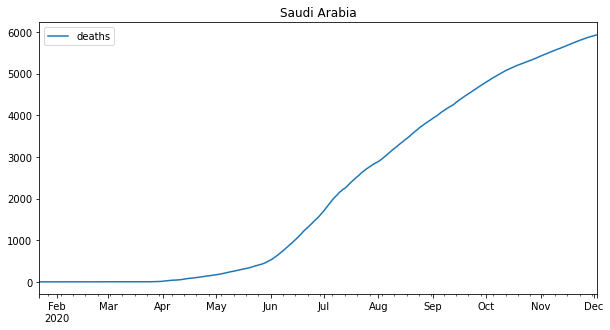

In [745]:
df_death.plot(figsize=(10,5), title=country);

In [746]:
train = df_death.iloc[:-daysToPredict]
test = df_death.iloc[-daysToPredict:]
print(len(train))
print(len(test))

310
7


In [747]:
scaler = MinMaxScaler()
scaler.fit(train);

In [748]:
scaledTrain = scaler.transform(train)
scaledTest = scaler.transform(test)

In [749]:
generator = TimeseriesGenerator(scaledTrain, scaledTrain, length=inputSize, batch_size=1)

In [750]:
print(len(scaledTrain))
print(len(generator))

310
303


In [751]:
model = Sequential()
model.add(LSTM(156, activation='relu', input_shape=(inputSize, numFeatures), return_sequences=True))

# model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(64, activation='relu'))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

# opt = Adam(lr=learningRate, decay=1e-6)
model.compile(optimizer="adam", loss='mse')

In [752]:
model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_63 (LSTM)               (None, 7, 150)            91200     
_________________________________________________________________
lstm_64 (LSTM)               (None, 7, 64)             55040     
_________________________________________________________________
lstm_65 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_72 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_41 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_73 (Dense)             (None, 1)                 33        
Total params: 159,745
Trainable params: 159,745
Non-trainable params: 0
_______________________________________________

In [753]:
val_set = np.append(scaledTrain[55], scaledTest)
val_set = val_set.reshape(daysToPredict+1,1)

In [754]:
val_gen = TimeseriesGenerator(val_set, val_set, length=inputSize, batch_size=numFeatures)

In [755]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [756]:
# model.fit_generator(generator, validation_data=val_gen, epochs=100, callbacks=[earlyStopping], steps_per_epoch=10);
model.fit_generator(generator, validation_data=val_gen, epochs=100, steps_per_epoch=10);

Epoch 1/100
10/10 [==============================] - 0s 49ms/step - loss: 0.2871 - val_loss: 0.9163
Epoch 2/100
10/10 [==============================] - 0s 10ms/step - loss: 0.0704 - val_loss: 0.7950
Epoch 3/100
10/10 [==============================] - 0s 9ms/step - loss: 0.1863 - val_loss: 0.5177
Epoch 4/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0894 - val_loss: 0.0019
Epoch 5/100
10/10 [==============================] - 0s 9ms/step - loss: 0.1330 - val_loss: 0.1303
Epoch 6/100
10/10 [==============================] - 0s 9ms/step - loss: 0.0237 - val_loss: 0.3114
Epoch 7/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0355 - val_loss: 0.2329
Epoch 8/100
10/10 [==============================] - 0s 9ms/step - loss: 0.0285 - val_loss: 0.1346
Epoch 9/100
10/10 [==============================] - 0s 9ms/step - loss: 0.0143 - val_loss: 0.1078
Epoch 10/100
10/10 [==============================] - 0s 9ms/step - loss: 0.0099 - val_loss: 0.2115
Epoch 1

Epoch 83/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0035 - val_loss: 0.0768
Epoch 84/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0090 - val_loss: 0.1436
Epoch 85/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0130 - val_loss: 0.1137
Epoch 86/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0054 - val_loss: 0.0764
Epoch 87/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0046 - val_loss: 0.0696
Epoch 88/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0075 - val_loss: 0.0836
Epoch 89/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0178 - val_loss: 0.2618
Epoch 90/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0293 - val_loss: 0.1346
Epoch 91/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 0.0713
Epoch 92/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0064 - val_loss: 0.1031


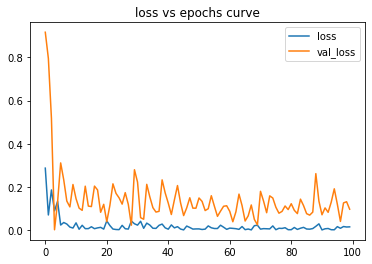

In [757]:
pd.DataFrame(model.history.history).plot(title="loss vs epochs curve");

In [758]:
testPred = []

firstEval = scaledTrain[-inputSize:]
currentBatch = firstEval.reshape(1, inputSize, numFeatures)

In [759]:
for i in range(len(test)+daysToPredict):
    currentPred = model.predict(currentBatch)[0]
    testPred.append(currentPred)
    currentBatch = np.append(currentBatch[:,1:,:], [[currentPred]], axis=1)

In [760]:
testPred

[array([0.9538964], dtype=float32),
 array([0.9550503], dtype=float32),
 array([0.95460165], dtype=float32),
 array([0.9525008], dtype=float32),
 array([0.94838107], dtype=float32),
 array([0.9422344], dtype=float32),
 array([0.93407], dtype=float32),
 array([0.9237201], dtype=float32),
 array([0.9218746], dtype=float32),
 array([0.91877747], dtype=float32),
 array([0.91476375], dtype=float32),
 array([0.9100499], dtype=float32),
 array([0.90508455], dtype=float32),
 array([0.9003365], dtype=float32)]

In [761]:
truePred = scaler.inverse_transform(testPred)
truePred[:,0]

array([5570.75499535, 5577.49369144, 5574.87360954, 5562.60478973,
       5538.54542732, 5502.6488781 , 5454.96874809, 5394.52550888,
       5383.74756336, 5365.66040039, 5342.22029209, 5314.69150543,
       5285.69377422, 5257.96518326])

In [762]:
timeSeriesArr = test.index
for k in range(0,daysToPredict):
    timeSeriesArr = timeSeriesArr.append(timeSeriesArr[-1:] + pd.DateOffset(1))

df_forecast = pd.DataFrame(columns=[feature, "prediction"], index=timeSeriesArr)
df_forecast

,deaths,prediction
2020-11-27,NaN,NaN
2020-11-28,NaN,NaN
2020-11-29,NaN,NaN
2020-11-30,NaN,NaN
2020-12-01,NaN,NaN
2020-12-02,NaN,NaN
2020-12-03,NaN,NaN
2020-12-04,NaN,NaN
2020-12-05,NaN,NaN
2020-12-06,NaN,NaN


In [763]:
df_forecast.loc[:,"prediction"] = truePred[:,0]
df_forecast.loc[:,feature] = test[feature]

In [764]:
df_forecast

,deaths,prediction
2020-11-27,5857.0,5570.754995
2020-11-28,5870.0,5577.493691
2020-11-29,5884.0,5574.873610
2020-11-30,5896.0,5562.604790
2020-12-01,5907.0,5538.545427
2020-12-02,5919.0,5502.648878
2020-12-03,5930.0,5454.968748
2020-12-04,NaN,5394.525509
2020-12-05,NaN,5383.747563
2020-12-06,NaN,5365.660400


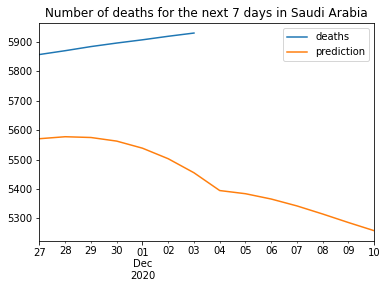

In [765]:
df_forecast.plot(title="Number of " + feature + " for the next " + str(daysToPredict) + " days in " + country);